### Install MXNet and autogluon

autogluon은 fit() - Training 함수 호출만으로 상당히 높은 정확도의 모델을 생성하며, 최신 기능들이 계속 업데이트 되어지고 있습니다.

source https://autogluon.mxnet.io/
##### 참고
* 한글 동영상 - https://youtu.be/xnimaVNTWfc
* aws 블로그 - https://aws.amazon.com/ko/blogs/opensource/machine-learning-with-autogluon-an-open-source-automl-library/
* 블로그의 샘플코드 - https://github.com/shashankprasanna/autogluon-demos/blob/master/otto-kaggle-example.ipynb
* 데모 - https://github.com/shashankprasanna/autogluon-demos
* 소스 - https://github.com/awslabs/autogluon
* paper - https://arxiv.org/abs/2003.06505 https://arxiv.org/pdf/2003.06505.pdf

In [2]:
import mxnet

In [70]:
from sagemaker.serializers import CSVSerializer

In [3]:
mxnet.__version__

'1.6.0'

In [49]:
!python -m pip install --upgrade pip

     |████████████████████████████████| 1.7 MB 1.6 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4


In [50]:
!pip install -q -U 'sagemaker>=2.66'

In [4]:
!pip install autogluon==0.1.0

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [5]:
from autogluon.tabular import TabularDataset, TabularPredictor

### Data Preparation

In [6]:
import pandas as pd

In [7]:
%%time
import sagemaker
from sagemaker import get_execution_role


role = get_execution_role()

CPU times: user 266 ms, sys: 33.2 ms, total: 299 ms
Wall time: 417 ms


In [8]:
import boto3
import os
role

'arn:aws:iam::806174985048:role/service-role/AmazonSageMaker-ExecutionRole-20201218T151409'

In [11]:
%%time
file = 'train.csv'
data_folder = '../../../../data/AdTalking'

file_path = os.path.join(data_folder, file)

raw_df = pd.read_csv(file_path, parse_dates=['click_time'])
raw_df

CPU times: user 1min 30s, sys: 17.3 s, total: 1min 48s
Wall time: 2min 4s


,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0
...,...,...,...,...,...,...,...,...
184903885,121312,12,1,10,340,2017-11-09 16:00:00,NaN,0
184903886,46894,3,1,19,211,2017-11-09 16:00:00,NaN,0
184903887,320126,1,1,13,274,2017-11-09 16:00:00,NaN,0
184903888,189286,12,1,37,259,2017-11-09 16:00:00,NaN,0


#### 데이터의 사이즈를 고려하여 샘플링을 하도록 합니다

In [12]:
sampling_rate = 0.01
df = raw_df.sample(frac=sampling_rate, random_state=100)

In [14]:
df.to_csv('sampled_data.csv')

In [15]:
def drop_column(raw_df, col):
    df = raw_df.drop(columns=[col])
    return df

df = drop_column(df, col='attributed_time')

In [16]:
print("min time: ", df.click_time.min())
print("max time: ", df.click_time.max())

min time:  2017-11-06 15:46:38
max time:  2017-11-09 16:00:00


In [17]:
def split_data_by_time(df, target_col, label_col, total_samples, split_rate, train_end, test_start, verbose=False):
    '''
    시간 관점으로 번반부튼 훈련, 후반부는 테스트 데이터로 해서 샘블링 함.
    '''
    
    # 훈련 데이터 셋
    train_df = df[df[target_col] <= train_end]   
    train_num = int(total_samples * (1 - split_rate))    # 훈련 샘플 데이터 수
    train_sample = train_df.sample(n = train_num, random_state=100)    # 샘플링    

    print("train sample shape: ", train_sample.shape)
    print("train min time: ", train_sample[target_col].min())
    print("train max time: ", train_sample[target_col].max())
    print("Train fraud ratio: ", round(train_sample[label_col].value_counts()[1] / train_sample.shape[0],5))
    print("# of Train frauds: ", train_sample[label_col].value_counts()[1])     


    # 테스트 데이터 셋    
    test_df = df[df[target_col] >= test_start]    
    test_num = int(total_samples * (split_rate))    # 테스트 샘플 데이터 수
    test_sample = test_df.sample(n = test_num, random_state=100)    
    

    print("\ntest sample shape: ", test_sample.shape)    
    print("test min time: ", test_sample[target_col].min())
    print("test max time: ", test_sample[target_col].max())
    print("Test fraud ratio: ", round(test_sample[label_col].value_counts()[1] / test_sample.shape[0],5))    
    print("# of test frauds: ", test_sample[label_col].value_counts()[1])         
    
    
    return train_sample, test_sample
    
train_df, test_df = split_data_by_time(
                       df=df, 
                       target_col='click_time', 
                       label_col = 'is_attributed',
                       total_samples=200000, 
                       split_rate=0.1, 
                       train_end='2017-11-08 23:59', 
                       test_start='2017-11-09 00:00',    
                       verbose = True,
                  )    

train sample shape:  (180000, 7)
train min time:  2017-11-06 15:50:26
train max time:  2017-11-08 23:58:59
Train fraud ratio:  0.00233
# of Train frauds:  419

test sample shape:  (20000, 7)
test min time:  2017-11-09 00:00:07
test max time:  2017-11-09 16:00:00
Test fraud ratio:  0.00245
# of test frauds:  49


In [18]:
train_df = drop_column(train_df, col='click_time')

In [19]:
test_df = drop_column(test_df, col='click_time')

In [56]:
train_df.to_csv("data/train.csv")

In [57]:
test_df.to_csv("data/test.csv")

In [21]:
label = 'is_attributed'

In [22]:
print("Summary of class variable: \n", train_df[label].describe())

Summary of class variable: 
 count    180000.000000
mean          0.002328
std           0.048191
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: is_attributed, dtype: float64


#### Test dataset - Split between X & Y

In [23]:
y_test = test_df[label]  # values to predict
test_data_nolab = test_df.drop(columns=[label])  # delete label column to prove we're not cheating

### Training

단 한 줄의 코드로 쉽게 AutoML을 수행할 수 있습니다. 문제 유형을 지정하지 않아도 자동으로 문제 유형을 파악하며, 별도의 피쳐 인코딩/변환을 수행하지 않아도 되며 결측치 또한 자동으로 처리할 수 있습니다. 이 때, 별도의 검증 데이터셋을 지정하지 않으면, AutoGluon은 데이터의 자동으로 훈련 데이터/검증 데이터를 분리합니다.

AutoGluon은 검증 데이터에서 최고의 성능을 내기 위한 다양한 조합을 반복적으로 수행하며, fit()에서 다양한 인수를 지정하여 자유롭게 AutoML을 수행할 수 있습니다.

##### Tip
GPU가 있다면, AutoGluon 0.1부터 LightGBM, CatBoost, XGBoost, NN, FastAI NN 모델 훈련 시 GPU로 훈련이 가능합니다.

In [24]:
%%time
predictor = TabularPredictor(label=label).fit(train_df)

No path specified. Models will be saved in: "AutogluonModels/ag-20211201_001849/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20211201_001849/"
AutoGluon Version:  0.1.0
Train Data Rows:    180000
Train Data Columns: 5
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Note: detected 72 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
Note: NumExpr detected 72 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:            

Worker timed out after 120 seconds. This might be caused by 

            - Slow transform. Please increase timeout to allow slower data loading in each worker.
            - Insufficient shared_memory if `timeout` is large enough.
            Please consider reduce `num_workers` or increase shared_memory in system.
            


Fitting model: NeuralNetFastAI ...


Epoch 22: early stopping


	0.9976	 = Validation accuracy score
	509.73s	 = Training runtime
	9.41s	 = Validation runtime
Fitting model: LightGBMLarge ...
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	0.9984	 = Validation accuracy score
	0.35s	 = Training runtime
	0.01s	 = Validation runtime


Fitting model: WeightedEnsemble_L2 ...
	0.9988	 = Validation accuracy score
	1.05s	 = Training runtime
	0.01s	 = Validation runtime
AutoGluon training complete, total runtime = 674.66s ...
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20211201_001849/")


In [25]:
test_data_nolab

,ip,app,device,os,channel
135866194,5336,9,1,17,134
164588981,41151,11,1,17,137
156791018,86638,9,1,19,107
144621959,12898,1,1,49,17
168912736,78574,18,1,13,107
...,...,...,...,...,...
168440752,53454,14,1,18,480
145697582,113827,9,1,22,442
147685230,320212,12,1,19,145
151870864,144897,12,1,15,259


### Evaluation

In [26]:
print("AutoGluon infers problem type is: ", predictor.problem_type)
print("AutoGluon identified the following types of features:")
print(predictor.feature_metadata)

AutoGluon infers problem type is:  binary
AutoGluon identified the following types of features:
('int', []) : 5 | ['ip', 'app', 'device', 'os', 'channel']


In [27]:
y_pred = predictor.predict(test_data_nolab)
y_pred.head()

135866194    0
164588981    0
156791018    0
144621959    0
168912736    0
Name: is_attributed, dtype: int64

In [28]:
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.99745
Evaluations on test data:
{
    "accuracy": 0.99745,
    "accuracy_score": 0.99745,
    "balanced_accuracy_score": 0.632277140218024,
    "matthews_corrcoef": 0.3497883756550038,
    "f1_score": 0.99745
}
Detailed (per-class) classification report:
{
    "0": {
        "precision": 0.9981974764670539,
        "recall": 0.9992481579870683,
        "f1-score": 0.9987225408912156,
        "support": 19951
    },
    "1": {
        "precision": 0.4642857142857143,
        "recall": 0.2653061224489796,
        "f1-score": 0.3376623376623377,
        "support": 49
    },
    "accuracy": 0.99745,
    "macro avg": {
        "precision": 0.7312415953763841,
        "recall": 0.632277140218024,
        "f1-score": 0.6681924392767766,
        "support": 20000
    },
    "weighted avg": {
        "precision": 0.9968893926497095,
        "recall": 0.99745,
        "f1-score": 0.9971029433933049,
        "support": 20000
    }
}


#### ROC, Precision, Confusion matrix

confusion matrix (cutoff=0.5)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19951
           1       0.46      0.27      0.34        49

    accuracy                           1.00     20000
   macro avg       0.73      0.63      0.67     20000
weighted avg       1.00      1.00      1.00     20000



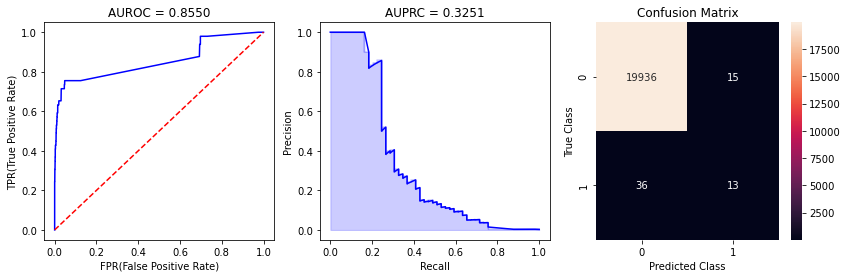

In [29]:
from src.utils import plot_all
y_prob = predictor.predict_proba(test_data_nolab)
y_prob_ = y_prob.iloc[:,-1]
plot_all(y_test, y_prob_)

In [30]:
results = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2     0.9988       0.247486    4.676809                0.005638           1.047958            2       True         13
1         LightGBMLarge     0.9984       0.005898    0.349896                0.005898           0.349896            1       True         12
2               XGBoost     0.9984       0.014941    5.651801                0.014941           5.651801            1       True         10
3      RandomForestEntr     0.9984       0.224052    2.238972                0.224052           2.238972            1       True          2
4              LightGBM     0.9980       0.006629    0.632614                0.006629           0.632614            1       True          7
5        ExtraTreesEntr     0.9980       0.223184    1.670884                0.223184           1.

In [31]:
predictor.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.9988,0.247486,4.676809,0.005638,1.047958,2,True,13
1,LightGBMLarge,0.9984,0.005898,0.349896,0.005898,0.349896,1,True,12
2,XGBoost,0.9984,0.014941,5.651801,0.014941,5.651801,1,True,10
3,RandomForestEntr,0.9984,0.224052,2.238972,0.224052,2.238972,1,True,2
4,LightGBM,0.9980,0.006629,0.632614,0.006629,0.632614,1,True,7
5,ExtraTreesEntr,0.9980,0.223184,1.670884,0.223184,1.670884,1,True,4
6,RandomForestGini,0.9980,0.224606,2.402699,0.224606,2.402699,1,True,1
7,ExtraTreesGini,0.9980,0.225219,1.362916,0.225219,1.362916,1,True,3
8,LightGBMXT,0.9976,0.005941,0.175538,0.005941,0.175538,1,True,8
9,CatBoost,0.9976,0.011898,1.039983,0.011898,1.039983,1,True,9


#### Feature Importance

In [32]:
predictor.feature_importance(data=test_df)

Computing feature importance via permutation shuffling for 5 features using 1000 rows with 3 shuffle sets...
	8.48s	= Expected runtime (2.83s per shuffle set)
	1.82s	= Actual runtime (Completed 3 of 3 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
channel,0.003667,0.003055,0.086595,3,0.021172,-0.013839
os,0.001333,0.001528,0.134852,3,0.010086,-0.007420
app,0.001000,0.001000,0.112702,3,0.006730,-0.004730
ip,0.001000,0.001000,0.112702,3,0.006730,-0.004730
device,0.000000,0.000000,0.500000,3,0.000000,0.000000


#### 특정 모델을 지정하여 검증

In [43]:
best_model = predictor.get_model_best() # validation 지표 기준
print("best_model: ", best_model)
list_models = predictor.get_model_names()
print("list_models: ", list_models)
selected_model = list_models[0]
print("selected_model: ", selected_model)

best_model:  WeightedEnsemble_L2
list_models:  ['RandomForestGini', 'RandomForestEntr', 'ExtraTreesGini', 'ExtraTreesEntr', 'KNeighborsUnif', 'KNeighborsDist', 'LightGBM', 'LightGBMXT', 'CatBoost', 'XGBoost', 'NeuralNetFastAI', 'LightGBMLarge', 'WeightedEnsemble_L2']
selected_model:  RandomForestGini


In [42]:
specific_model = predictor._trainer.load_model(selected_model)
model_info = specific_model.get_info()
model_info

{'name': 'RandomForestGini',
 'model_type': 'RFModel',
 'problem_type': 'binary',
 'eval_metric': 'accuracy',
 'stopping_metric': 'accuracy',
 'fit_time': 2.4026994705200195,
 'num_classes': 2,
 'predict_time': 0.22460603713989258,
 'val_score': 0.998,
 'hyperparameters': {'n_estimators': 300,
  'n_jobs': -1,
  'random_state': 0,
  'criterion': 'gini'},
 'hyperparameters_fit': {'n_estimators': 300},
 'hyperparameters_nondefault': ['criterion'],
 'ag_args_fit': {'max_memory_usage_ratio': 1.0,
  'max_time_limit_ratio': 1.0,
  'max_time_limit': None,
  'min_time_limit': 0,
  'ignored_type_group_special': None,
  'ignored_type_group_raw': ['object'],
  'get_features_kwargs': None,
  'get_features_kwargs_extra': None},
 'num_features': 5,
 'features': ['ip', 'app', 'device', 'os', 'channel'],
 'feature_metadata': <autogluon.core.features.feature_metadata.FeatureMetadata at 0x7f2b58434f60>,
 'memory_size': 21960891}

### Train and deploy using SageMaker

In [45]:
import sagemaker

# Helper wrappers referred earlier
from ag_model import (
    AutoGluonTraining,
    AutoGluonInferenceModel,
    AutoGluonTabularPredictor,
)
from sagemaker import utils

role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.session.Session()
region = sagemaker_session._region_name

bucket = sagemaker_session.default_bucket()
s3_prefix = f"autogluon_sm/{utils.sagemaker_timestamp()}"
output_path = f"s3://{bucket}/{s3_prefix}/output/"

In [61]:
ag = AutoGluonTraining(
    role=role,
    entry_point="scripts/tabular_train.py",
    region=region,
    instance_count=1,
    instance_type="ml.c5n.18xlarge",
    framework_version="0.3.1",
    base_job_name="autogluon-tabular-train",
)

In [62]:
s3_prefix = f"autogluon_sm/{utils.sagemaker_timestamp()}"
train_input = ag.sagemaker_session.upload_data(
    path=os.path.join("data", "train.csv"), key_prefix=s3_prefix
)
eval_input = ag.sagemaker_session.upload_data(
    path=os.path.join("data", "test.csv"), key_prefix=s3_prefix
)
config_input = ag.sagemaker_session.upload_data(
    path=os.path.join("config", "config-med.yaml"), key_prefix=s3_prefix
)


In [63]:
job_name = utils.unique_name_from_base("test-autogluon-image")
ag.fit(
    {"config": config_input, "train": train_input, "test": eval_input},
    job_name=job_name,
)

Defaulting to the only supported framework/algorithm version: latest.
Ignoring unnecessary instance type: None.
Creating training-job with name: test-autogluon-image-1638327738-14ba


2021-12-01 03:02:18 Starting - Starting the training job...
2021-12-01 03:02:42 Starting - Launching requested ML instancesProfilerReport-1638327738: InProgress
.........
2021-12-01 03:04:06 Starting - Preparing the instances for training......
2021-12-01 03:05:16 Downloading - Downloading input data
2021-12-01 03:05:16 Training - Downloading the training image...
2021-12-01 03:05:44 Training - Training image download completed. Training in progress..2021-12-01 03:05:45,301 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2021-12-01 03:05:45,302 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-12-01 03:05:45,312 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{}', 'SM_USER_ENTRY_POINT': 'tabular_train.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_

#### Model Export

In [64]:
!aws s3 cp {ag.model_data} .

download: s3://sagemaker-ap-northeast-2-806174985048/test-autogluon-image-1638327738-14ba/output/model.tar.gz to ./model.tar.gz


In [65]:
!ls -alF model.tar.gz

-rw-rw-r-- 1 ec2-user ec2-user 56386489 Dec  1 03:17 model.tar.gz


### Endpoint Deployment

In [66]:
endpoint_name = sagemaker.utils.unique_name_from_base("sagemaker-autogluon-serving-trained-model")

model_data = sagemaker_session.upload_data(
    path=os.path.join(".", "model.tar.gz"), key_prefix=f"{endpoint_name}/models"
)

Deploy remote or local endpoint

In [67]:
instance_type = "ml.m5.2xlarge"
# instance_type = 'local'

In [68]:
model = AutoGluonInferenceModel(
    model_data=model_data,
    role=role,
    region=region,
    framework_version="0.3.1",
    instance_type=instance_type,
    source_dir="scripts",
    entry_point="tabular_serve.py",
)

In [71]:
%%time
predictor = model.deploy(
    initial_instance_count=1, serializer=CSVSerializer(), instance_type=instance_type
)

Creating model with name: autogluon-inference-2021-12-01-03-22-59-714
Creating endpoint with name autogluon-inference-2021-12-01-03-22-59-992


-----!

#### Predict on unlabeled test data

In [77]:
df = pd.read_csv("data/test.csv")
data = df.drop(columns="is_attributed")[:100].values

In [79]:
preds = predictor.predict(data)

In [81]:
p = pd.DataFrame({"preds": pd.DataFrame(preds)[0], "actual": df["is_attributed"][: len(preds)]})
p.head()

,preds,actual
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0


In [82]:
print(f"{(p.preds==p.actual).astype(int).sum()}/{len(p)} are correct")

100/100 are correct


### Clean up Endpoint

In [84]:
predictor.delete_endpoint()

Deleting endpoint configuration with name: autogluon-inference-2021-12-01-03-22-59-992
Deleting endpoint with name: autogluon-inference-2021-12-01-03-22-59-992
